# LAB 3 - MORE ON LINEAR REGRESSION IN PYTHON

From previous lab, we learned how to use `sklearn` package to conduct linear regression. In this lab, we will show another approach to do the linear regression in Python, using the `statsmodels` library.

## Load the data

In [1]:
import numpy as np # math arrays manipulation
import pandas as pd # for data management
import os 
from matplotlib import pyplot as plt # for plot

In [2]:
path = os.getcwd() + "/wine_agg.csv" # make sure you are in the correct directory
wine = pd.read_csv(path)

FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\minon\\Desktop\\Berkeley\\Analytics\\INDENG 242\\Discussion\\Discussion3/wine_agg.csv'

## Training the model with `statsmodel` library.

In [ ]:
# Import statsmodels for linear regression modeling.

import statsmodels.api as sm

wine_train = wine.sample(frac=0.8, random_state=1)
wine_test = wine.drop(wine_train.index)

# Choose the features to be used
cols = ['WinterRain', 'HarvestRain', 'GrowTemp', 'HarvestTemp', 'Age', 'FrancePop', 'USAlcConsump']
X_train = wine_train[cols]
y_train = wine_train['LogAuctionIndex']

# We must add an intercept as the standard model doesn't automatically fit one
X_train = sm.add_constant(X_train)

# fit the data to the model
model = sm.OLS(y_train, X_train).fit()

print(model.summary())

NameError: name 'wine' is not defined

## An R-styled Coding Format

In [4]:
import statsmodels.formula.api as smf

model1 = smf.ols(formula='LogAuctionIndex ~ WinterRain + HarvestRain + GrowTemp + HarvestTemp + Age + FrancePop + USAlcConsump',
                 data=wine_train).fit()

print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:        LogAuctionIndex   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     19.43
Date:                Fri, 09 Sep 2022   Prob (F-statistic):           2.30e-09
Time:                        00:02:57   Log-Likelihood:                -4.7464
No. Observations:                  37   AIC:                             25.49
Df Residuals:                      29   BIC:                             38.38
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.0080     10.355      0.097   

In [5]:
coef_df = pd.DataFrame(model1.summary().tables[1].data)
coef_df.columns = coef_df.iloc[0]
coef_df.index = coef_df[""]
coef_df = coef_df.iloc[1:,1:]
coef_df

,coef,std err,t,P>|t|,[0.025,0.975]
,,,,,,
Intercept,1.0080,10.355,0.097,0.923,-20.171,22.187
WinterRain,0.0011,0.000,2.290,0.029,0.000,0.002
HarvestRain,-0.0040,0.001,-4.513,0.000,-0.006,-0.002
GrowTemp,0.7330,0.104,7.072,0.000,0.521,0.945
HarvestTemp,-0.0773,0.048,-1.595,0.122,-0.176,0.022
Age,-0.0127,0.056,-0.226,0.823,-0.128,0.102
FrancePop,-0.0993,0.163,-0.609,0.547,-0.432,0.234
USAlcConsump,0.0601,0.117,0.512,0.613,-0.180,0.300


## Model Evaluation

### Out-of-sample R-squared

In [6]:
# Compute Out-of-sample R-squared using the test set

def OSR2(model, df_train, df_test, dependent_var):   
    
    y_test = df_test[dependent_var]
    y_pred = model.predict(df_test)
    SSE = np.sum((y_test - y_pred)**2)
    SST = np.sum((y_test - np.mean(df_train[dependent_var]))**2)    
    
    return 1 - SSE/SST

In [7]:
OSR2(model1, wine_train, wine_test, 'LogAuctionIndex')

0.49220255538279334

### VIF: Detect the multicollinearity in the model.

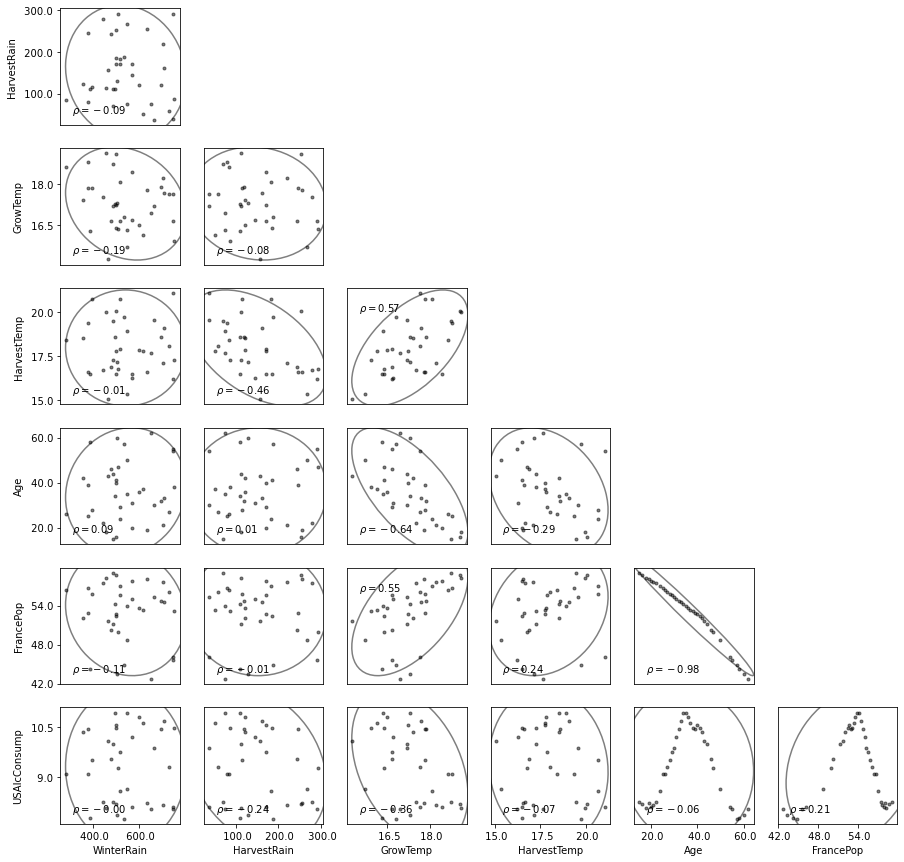

In [8]:
from statsmodels.graphics.plot_grids import scatter_ellipse
fig = plt.figure(figsize=(15, 15))
scatter_ellipse(wine_train[cols], varnames=wine_train[cols].columns, fig=fig)
plt.show()

In [9]:
# Calculate Variance Inflation Factor for each explanatory variable by a for loop. 

from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = [variance_inflation_factor(X_train.values, i) for i in range(1, X_train.shape[1])] 
vif

[1.1813677850579196,
 1.6356958235632473,
 3.6444515354740545,
 2.0674790113629196,
 204.9048830873669,
 206.00094993847458,
 6.287458625009638]

In [10]:
## Writing a function to calculate the VIF.

def VIF(df, columns):
    
    values = sm.add_constant(df[columns]).values  # the dataframe passed to VIF must include the intercept term. We add it the same way we did before.
    num_columns = len(columns)+1
    vif = [variance_inflation_factor(values, i) for i in range(num_columns)]
    
    return pd.Series(vif[1:], index=columns)

In [11]:
cols = ['WinterRain', 'HarvestRain', 'GrowTemp', 'HarvestTemp', 'Age', 'FrancePop', 'USAlcConsump']
VIF(wine_train, cols)

WinterRain        1.181368
HarvestRain       1.635696
GrowTemp          3.644452
HarvestTemp       2.067479
Age             204.904883
FrancePop       206.000950
USAlcConsump      6.287459
dtype: float64

## Model Tuning

### 1. Remove variables that have high VIF.

In [12]:
## Removing the 'FrancePop'.

model2 = smf.ols(formula='LogAuctionIndex ~ WinterRain + HarvestRain + GrowTemp + HarvestTemp + Age + USAlcConsump',
                 data=wine_train).fit()

print(model2.summary())

## Observe the p-value of Age.

VIF(wine_train, ['WinterRain', 'HarvestRain', 'GrowTemp', 'HarvestTemp', 'Age', 'USAlcConsump'])

                            OLS Regression Results                            
Dep. Variable:        LogAuctionIndex   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     23.09
Date:                Fri, 09 Sep 2022   Prob (F-statistic):           5.39e-10
Time:                        00:03:11   Log-Likelihood:                -4.9819
No. Observations:                  37   AIC:                             23.96
Df Residuals:                      30   BIC:                             35.24
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -5.1665      2.121     -2.436   

WinterRain      1.085835
HarvestRain     1.465481
GrowTemp        3.532736
HarvestTemp     2.049022
Age             2.141318
USAlcConsump    1.593824
dtype: float64

In [13]:
OSR2(model2, wine_train, wine_test, 'LogAuctionIndex')

0.5209082286855509

### 2. Feature Engineering: create an interaction variable

In [17]:
# Let's create a new variable and test its predictive power.

model3 = smf.ols(formula='LogAuctionIndex ~ WinterRain + HarvestRain + GrowTemp*Age',
                 data=wine_train).fit()

print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:        LogAuctionIndex   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     27.57
Date:                Fri, 09 Sep 2022   Prob (F-statistic):           1.51e-10
Time:                        00:03:48   Log-Likelihood:                -5.5513
No. Observations:                  37   AIC:                             23.10
Df Residuals:                      31   BIC:                             32.77
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -9.3127      3.519     -2.646   

In [18]:
OSR2(model3, wine_train, wine_test, 'LogAuctionIndex')

0.55062174061249

### 3. Adding categorical variables

In [19]:
### Read in the new file
wine_new = pd.read_csv("wine_disagg.csv")

wine_new_train = wine_new.sample(frac=0.8, random_state=1)
wine_new_test = wine_new.drop(wine_new_train.index)

In [20]:
model4 = smf.ols(formula='LogAuction ~ Winery + WinterRain + HarvestRain + GrowTemp + Age',
                 data=wine_new_train).fit()

print(model4.summary())

                            OLS Regression Results                            
Dep. Variable:             LogAuction   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     84.32
Date:                Fri, 09 Sep 2022   Prob (F-statistic):           3.97e-43
Time:                        00:05:51   Log-Likelihood:                -53.035
No. Observations:                 118   AIC:                             124.1
Df Residuals:                     109   BIC:                             149.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [21]:
OSR2(model4, wine_new_train, wine_new_test, 'LogAuction')

0.8370581453986516

In [22]:
## Put back the interaction variable.
model5 = smf.ols(formula='LogAuction ~ Winery + WinterRain + HarvestRain + GrowTemp*Age',
                 data=wine_new_train).fit()

print(model5.summary())

                            OLS Regression Results                            
Dep. Variable:             LogAuction   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     74.48
Date:                Fri, 09 Sep 2022   Prob (F-statistic):           3.31e-42
Time:                        00:05:54   Log-Likelihood:                -52.892
No. Observations:                 118   AIC:                             125.8
Df Residuals:                     108   BIC:                             153.5
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [23]:
OSR2(model5, wine_new_train, wine_new_test, 'LogAuction')

0.8422419164205246